In [1]:
import sys
from sklearn.utils.extmath import svd_flip, randomized_svd
from scipy.sparse.linalg import svds
import numpy as np
import torch
import scipy.io as sio
import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
if device == 'cuda':
    # when using GPU use this block of code
    gpu_path = '/home/akumar/data/KLCPD_data/code'
    sys.path.append(gpu_path)
    # from main import KL_CPD
    from main import KL_CPD
    codar_file_path = '/home/akumar/data/KLCPD_data/collision_0-256.mat'
else:
    # when using CPU use this block of code
    # cpu_path = ''
    # sys.path.append(cpu_path)
    # from main import KL_CPD
    codar_file_path = '../test/data/collision_0-256.mat'

codar_file_path

'/home/akumar/data/KLCPD_data/collision_0-256.mat'

In [4]:
def get_codar_coordinates():
    codar_data = sio.loadmat(codar_file_path)
    (x1, y1, z1) = codar_data['trace'].shape
    return codar_data['trace'].reshape(x1, y1*z1, order='C')

In [5]:
components = 2
svd_method = 'no method selected'
selected_dataset = 'codar'

In [6]:
codar = get_codar_coordinates()
codar.shape

(255, 27099)

In [7]:
def train_and_pred_dataset(dataset):
    dim_codar = dataset.shape[1]
    model_codar = KL_CPD(dim_codar).to(device)
    model_codar.fit(dataset)
    return model_codar.predict(dataset)

In [8]:
def plot_data(dataset, predictions, reduction_method):
    components = dataset.shape[1]
    for i in range(components):
        plt.subplot(components+1,1,i+1)
        plt.plot(dataset[:,i])
        plt.title(f'Component {i+1}')
        ymin = min(dataset[:,0])-1
        ymax = max(dataset[:,0])+1
        plt.ylim([ymin, ymax])
        plt.subplot(components+1, 1, components+1)

    plt.plot(predictions)
    plt.title('MMD')
    plt.suptitle(f'{reduction_method} with {components} component(s) visualization')
    plt.tight_layout()
    plt.show()

Principal Component Analysis Section

In [32]:
cov_mat = np.cov(codar.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
eigen_vals, eigen_vecs

(array([ 6.59024240e+02+0.j,  8.12852957e+01+0.j,  3.10961215e+01+0.j, ...,
        -1.56163994e-19+0.j,  4.58902443e-19+0.j, -5.86473275e-19+0.j]),
 array([[-6.27967495e-03+0.j,  1.49379954e-03+0.j, -2.80974355e-03+0.j,
         ..., -1.62785964e-04+0.j,  2.63716566e-03+0.j,
         -3.82815329e-04+0.j],
        [-4.27663530e-03+0.j, -2.35204793e-03+0.j, -4.81353582e-03+0.j,
         ..., -2.49380548e-06+0.j,  1.95302295e-05+0.j,
         -3.42132573e-07+0.j],
        [-1.53941105e-02+0.j,  1.31851800e-02+0.j, -5.83808929e-03+0.j,
         ...,  8.81251888e-06+0.j,  7.96805979e-06+0.j,
         -8.51715760e-06+0.j],
        ...,
        [-5.77443969e-03+0.j, -3.47275827e-02+0.j,  6.30102514e-02+0.j,
         ...,  1.06768637e-03+0.j, -5.37177310e-04+0.j,
         -2.74567965e-04+0.j],
        [-3.11126331e-03+0.j,  3.04775031e-02+0.j, -3.53154914e-02+0.j,
         ...,  3.85429871e-03+0.j, -1.21767119e-03+0.j,
         -3.85263407e-03+0.j],
        [-8.87475270e-03+0.j,  5.39970952e-

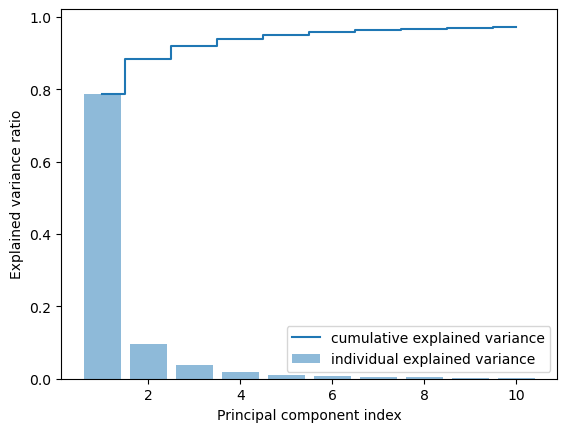

In [37]:
# calculate cumulative sum of explained variances
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

# plot explained variances
plt.bar(range(1,11), var_exp[:10], alpha=0.5,
        align='center', label='individual explained variance')
plt.step(range(1,11), cum_var_exp[:10], where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()

In [38]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

In [39]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W:\n', w)

Matrix W:
 [[-0.00627967+0.j  0.0014938 +0.j]
 [-0.00427664+0.j -0.00235205+0.j]
 [-0.01539411+0.j  0.01318518+0.j]
 ...
 [-0.00577444+0.j -0.03472758+0.j]
 [-0.00311126+0.j  0.0304775 +0.j]
 [-0.00887475+0.j  0.0539971 +0.j]]


In [41]:
codar[0].dot(w)

array([-32.07069121+0.j,  49.4098845 +0.j])

In [45]:
codar_pca = codar.dot(w)

In [48]:
codar.shape, codar_pca.shape

((255, 27099), (255, 2))

In [49]:
dim_codar = codar_pca.shape[1]
model_codar = KL_CPD(dim_codar).to(device)
dim_codar

2

In [50]:
model_codar.fit(codar_pca)

/data/akumar/KLCPD_data/code/data.py:39: ComplexWarning: Casting complex values to real discards the imaginary part
  Y_hankel[t, d, :] = ts[t-self.sub_dim+1:t+1, d].flatten()
  0%|                                                  | 0/100 [00:00<?, ?it/s]/data/akumar/KLCPD_data/code/main.py:203: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /opt/conda/conda-bld/pytorch_1682343970094/work/aten/src/ATen/native/Copy.cpp:276.)
  X_p, X_f, Y_true = [batch[key].float().to(self.device) for key in ['X_p', 'X_f', 'Y']]
100%|████████████████████████████████████████| 100/100 [00:42<00:00,  2.38it/s]


In [51]:
preds_codar = model_codar.predict(codar_pca)

/data/akumar/KLCPD_data/code/data.py:39: ComplexWarning: Casting complex values to real discards the imaginary part
  Y_hankel[t, d, :] = ts[t-self.sub_dim+1:t+1, d].flatten()


/home/akumar/miniconda3/envs/cuda_env/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/akumar/miniconda3/envs/cuda_env/lib/python3.11/site-packages/matplotlib/transforms.py:2860: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


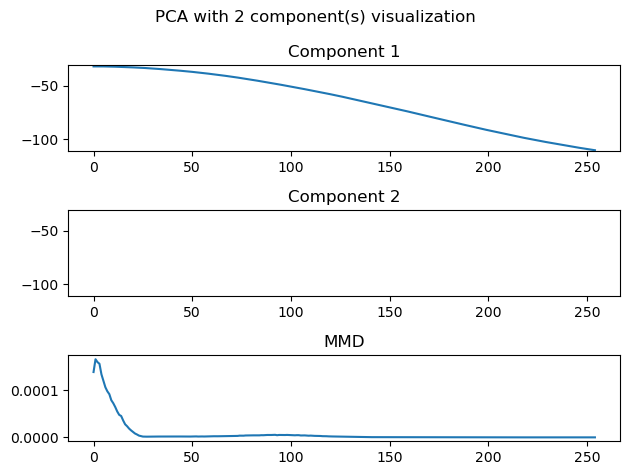

In [53]:
for i in range(components):
    plt.subplot(components+1,1,i+1)
    plt.plot(codar_pca[:,i])
    plt.title(f'Component {i+1}')
    ymin = min(codar_pca[:,0])-1
    ymax = max(codar_pca[:,0])+1
    plt.ylim([ymin, ymax])
    plt.subplot(components+1, 1, components+1)

plt.plot(preds_codar)
plt.title('MMD')
plt.suptitle(f'PCA with {components} component(s) visualization')
plt.tight_layout()
plt.show()

In [15]:
from sklearn.decomposition import PCA

# intialize pca
pca = PCA(n_components=2)

# fit and transform data
pca_data = pca.fit_transform(codar)

# pca_reduced will contain the 2-d projects of simple data
print("shape of pca_reduced.shape = ", pca_data.shape)


shape of pca_reduced.shape =  (255, 2)


In [19]:
preds_codar = train_and_pred_dataset(pca_data)

100%|████████████████████████████████████████| 100/100 [00:38<00:00,  2.59it/s]


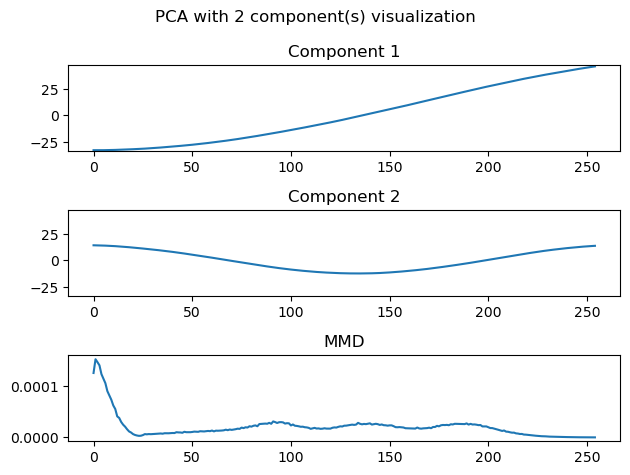

In [22]:
plot_data(pca_data, preds_codar, reduction_method='PCA')

Scaled PCA

In [16]:
from sklearn.preprocessing import StandardScaler

# standardize the data
scaler = StandardScaler()
codar_scaled = scaler.fit_transform(codar)

# fit and transform data
pca_data = pca.fit_transform(codar_scaled)

In [24]:
preds_codar_scaled_pca = train_and_pred_dataset(pca_data)

100%|████████████████████████████████████████| 100/100 [00:36<00:00,  2.75it/s]


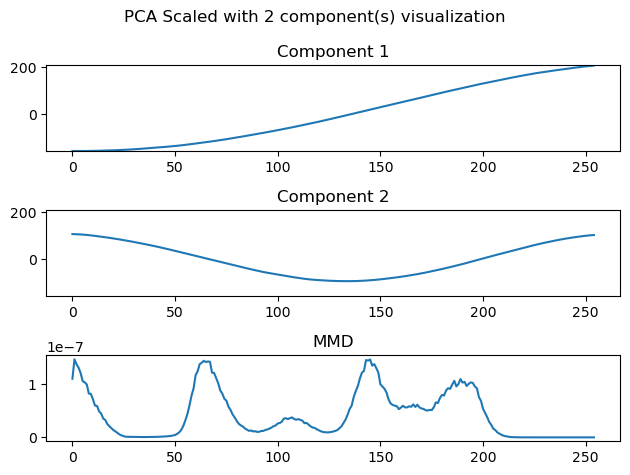

In [25]:
plot_data(pca_data, preds_codar_scaled_pca, reduction_method='PCA Scaled')

Truncated Scaled SVD

In [26]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=4, algorithm='randomized', random_state=0)
codar_svd_scaled = svd.fit_transform(codar_scaled)

In [29]:
preds_codar_scaled_svd = train_and_pred_dataset(codar_svd_scaled)

100%|████████████████████████████████████████| 100/100 [00:34<00:00,  2.90it/s]


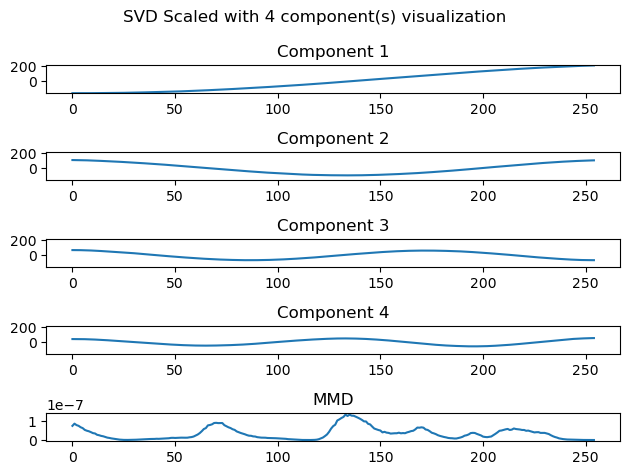

In [30]:
plot_data(codar_svd_scaled, preds_codar_scaled_svd, reduction_method='SVD Scaled', components=4)

In [23]:
svd = TruncatedSVD(n_components=2, algorithm='arpack', random_state=0)
codar_svd = svd.fit_transform(codar)

In [24]:
preds_codar_svd = train_and_pred_dataset(codar_svd)

100%|████████████████████████████████████████| 100/100 [00:34<00:00,  2.90it/s]


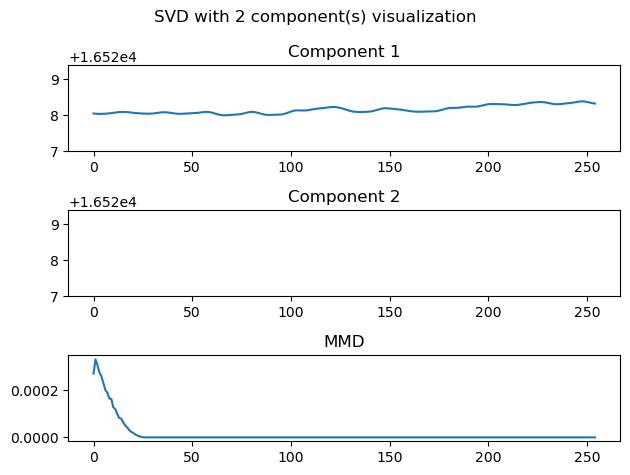

In [25]:
plot_data(codar_svd, preds_codar_svd, reduction_method='SVD')

Kernel PCA

In [31]:
from sklearn.decomposition import KernelPCA

# intialize pca
kpca = KernelPCA(n_components=2, kernel='rbf', random_state=42)

# fit and transform data
kpca_data = kpca.fit_transform(codar)

In [33]:
preds_codar_kpca = train_and_pred_dataset(kpca_data)

100%|████████████████████████████████████████| 100/100 [00:34<00:00,  2.91it/s]


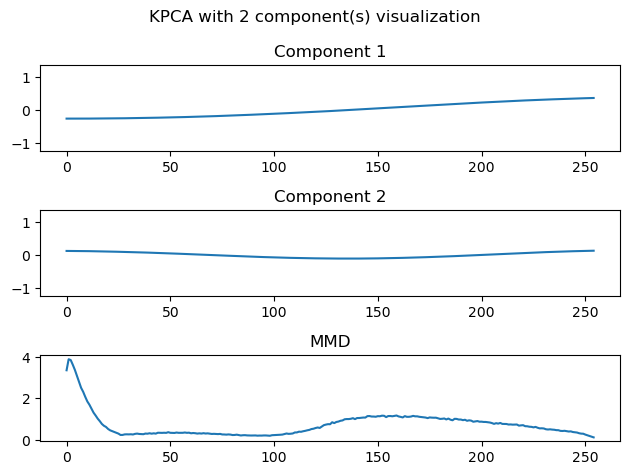

In [34]:
plot_data(kpca_data, preds_codar_kpca, reduction_method='KPCA')

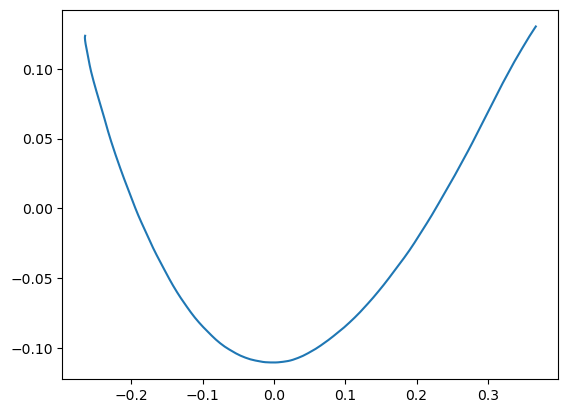

In [36]:
plt.plot(kpca_data[:,0], kpca_data[:,1])

Test model on given datasets using different dimensionality reduction techniques

In [7]:
fishkiller_data = '/home/akumar/data/KLCPD_data/fishkiller.mat'
yahoo_data = '/home/akumar/data/KLCPD_data/yahoo.mat'

fishkiller = sio.loadmat(fishkiller_data)
yahoo = sio.loadmat(yahoo_data)

fishkiller['Y'].shape, yahoo['Y'].shape

((45175, 1), (1427, 1))

In [13]:
# fishkiller_preds = train_and_pred_dataset(fishkiller['Y'])
yahoo_preds = train_and_pred_dataset(yahoo['Y'])

100%|████████████████████████████████████████| 100/100 [03:45<00:00,  2.25s/it]


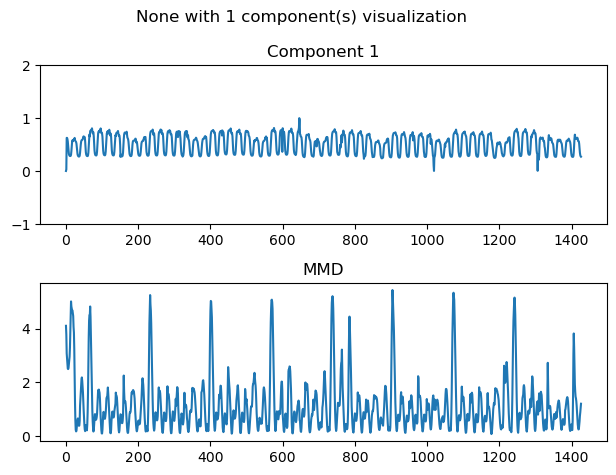

In [17]:
plot_data(yahoo['Y'], yahoo_preds, reduction_method='None')

TCNE PCA Scaled

In [10]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

# intialize pca
pca = PCA(n_components=2)

# standardize the data
scaler = StandardScaler()
codar_scaled = scaler.fit_transform(codar)

# fit and transform data
pca_data = pca.fit_transform(codar_scaled)

tsne = TSNE()
tsne_codar = tsne.fit_transform(pca_data)

In [13]:
preds_codar_scaled_pca_tcne = train_and_pred_dataset(tsne_codar)

100%|████████████████████████████████████████| 100/100 [00:41<00:00,  2.43it/s]


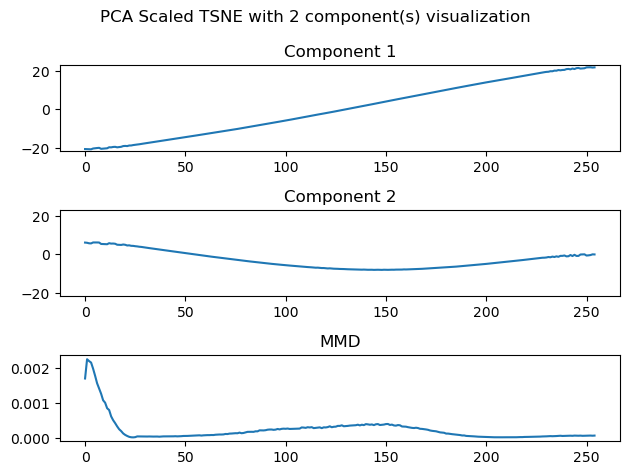

In [14]:
plot_data(tsne_codar, preds_codar_scaled_pca_tcne, reduction_method='PCA Scaled TSNE')

TSNE Scaled

In [15]:
tsne_codar = tsne.fit_transform(codar_scaled)

In [16]:
preds_codar_scaled_tcne = train_and_pred_dataset(tsne_codar)

100%|████████████████████████████████████████| 100/100 [00:39<00:00,  2.53it/s]


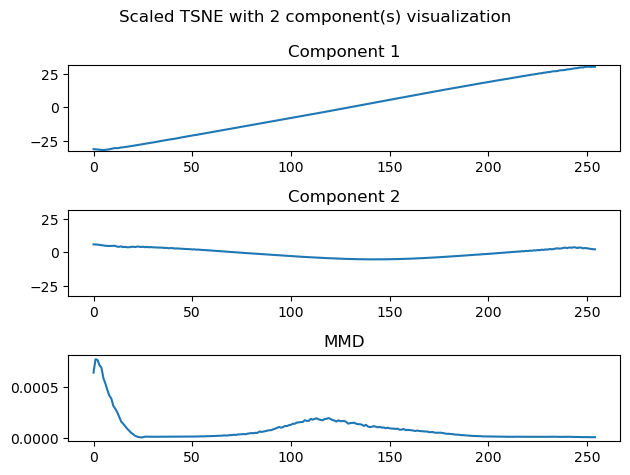

In [17]:
plot_data(tsne_codar, preds_codar_scaled_tcne, reduction_method='Scaled TSNE')

TSNE on HASC Dataset

In [20]:
hasc = sio.loadmat('/home/akumar/data/KLCPD_data/hasc-1.mat')

In [21]:
hasc_scaled = scaler.fit_transform(hasc['Y'])
tsne_hasc_scaled = tsne.fit_transform(hasc_scaled)

In [22]:
tsne_hasc_scaled.shape

(39397, 2)

In [23]:
preds_hasc_scaled_tcne = train_and_pred_dataset(tsne_hasc_scaled)

100%|██████████████████████████████████████| 100/100 [1:47:11<00:00, 64.31s/it]


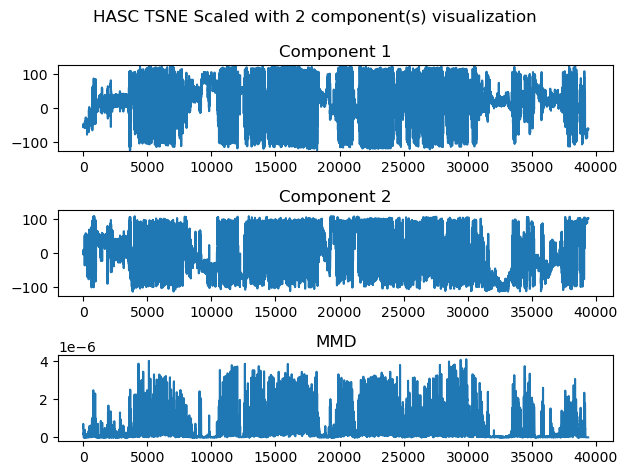

In [24]:
plot_data(tsne_hasc_scaled, preds_hasc_scaled_tcne, reduction_method='HASC TSNE Scaled')